In [94]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Loading the data

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Example for the data from fashion_mnist

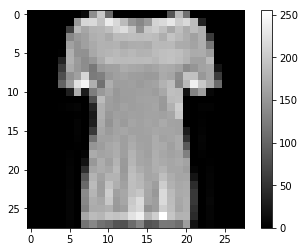

In [5]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [6]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

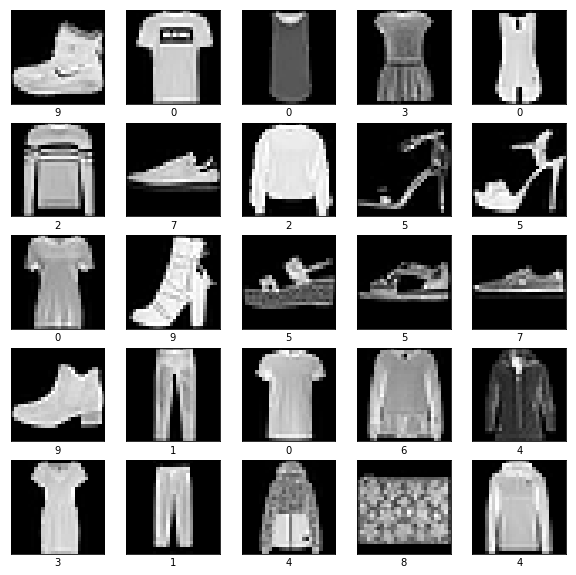

In [7]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard(agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

## Filter 0, 4 and 8 labels to create new data

Condition for getting only 0, 4 and 8 labels in every array

In [8]:
train_condition = ((train_labels == 0) | (train_labels == 4) | (train_labels == 8))
test_condition = ((test_labels == 0) | (test_labels == 4) | (test_labels == 8))

Filtering train and test data by the previous condition

In [9]:
train_labels_filtered = train_labels[train_condition]
train_images_filtered = train_images[train_condition]
test_labels_filtered = test_labels[test_condition]
test_images_filtered = test_images[test_condition]

In [10]:
print('Number of elements in train_labels_filtered: ', '{0:,}'.format(len(train_labels_filtered)))
print('Number of elements in train_iamges_filtered: ', '{0:,}'.format(len(train_images_filtered)))
print('Number of elements in train_labels_filtered: ', '{0:,}'.format(len(test_labels_filtered)))
print('Number of elements in train_iamges_filtered: ', '{0:,}'.format(len(test_images_filtered)))

Number of elements in train_labels_filtered:  18,000
Number of elements in train_iamges_filtered:  18,000
Number of elements in train_labels_filtered:  3,000
Number of elements in train_iamges_filtered:  3,000


Check for unique labels in new data

In [11]:
print('Labels for train data: ', np.unique(train_labels_filtered))
print('Labels for test data: ', np.unique(train_labels_filtered))

Labels for train data:  [0 4 8]
Labels for test data:  [0 4 8]


## Creating a label dictionary to match the description with each code

In [12]:
label_dict = dict()
label_dict[0] = ['T-shirt/top']
label_dict[1] = ['Trouser']
label_dict[2] = ['Pullover']
label_dict[3] = ['Dress']
label_dict[4] = ['Coat']
label_dict[5] = ['Sandal']
label_dict[6] = ['Shirt']
label_dict[7] = ['Sneaker']
label_dict[8] = ['Bag']
label_dict[9] = ['Ankle boot']

In [13]:
label_dict

{0: ['T-shirt/top'],
 1: ['Trouser'],
 2: ['Pullover'],
 3: ['Dress'],
 4: ['Coat'],
 5: ['Sandal'],
 6: ['Shirt'],
 7: ['Sneaker'],
 8: ['Bag'],
 9: ['Ankle boot']}

## Defining the function for the Logistic Regression

In [123]:
def logistic_model(epochs, lr, batch, x_model, y_model, W_model, b_model, k):
    
    tf.reset_default_graph()
    
    #Hyperparameters
    epochs = epochs #parameter of the function
    lr = lr #parameter of the function
    
    #Learnable parameters
    W = tf.Variable(W_model, name = 'W')
    b = tf.Variable(b_model, name = 'b')
    
    #Other parameters
    k = k #parameter of the function: prints every k
    batch_size = batch
    m = x_model.shape[1] #parameter of the function for the number of columns of matrix x
    y_col = y_model.shape[1] #parameter of the function for the number of columns of matrix y
    
    #Model variables
    X = tf.placeholder('float64', name = 'X', shape = [batch_size, m])
    Y = tf.placeholder('float64', name = 'y', shape = [batch_size, y_col])
    
    #Hypothesis
    with tf.name_scope('Hypothesis'):
        logits = tf.add(tf.matmul(X, W, name = 'Matrix_Product'), b, name = 'Logits')
        y_hat = tf.nn.softmax(logits, name = 'Hypothesis_Softmax')
    
    #Cost Function - J(m,b)
    with tf.name_scope('Cost_Function'):
        error = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_hat), reduction_indices=[1]))
    
    #Gradient Descent
    with tf.name_scope('Gradient'):
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(error)
    
    #For accuracy
    with tf.name_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(Y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    #Creating error summaries
    error_summary = tf.summary.scalar(name = 'Error_Summary', tensor = error)
    accuracy_summary = tf.summary.scalar(name = 'Accuracy_Summary', tensor = accuracy)
    
    graph_dir = (
        './graphs/graph_epochs='+str(epochs)+
        'lr='+str(lr)+
        'batch='+str(batch)
    )
    
    with tf.Session() as sess:
        
        tf.initialize_all_variables().run()
        print('Variables successfully initialized')
        
        writer = tf.summary.FileWriter(graph_dir, sess.graph)
        print('Directory created in', graph_dir)
        
        for epoch in range(epochs):
            
            forBatch = (epoch * batch_size) % (x_train.shape[0] - batch_size)
            print(forBatch)
            
            feed_dict = {X : x_train[forBatch:(forBatch+batch_size)], 
                         Y : y_train[forBatch:(forBatch+batch_size)]}
            feed_dict_accuracy = {y_hat : sess.run(y_hat, feed_dict),
                                  Y : y_train[forBatch:(forBatch+batch_size)]}
            
            sess.run(optimizer, feed_dict)

            if (epoch+1)%k == 0:

                e = sess.run(error, feed_dict)
                a = sess.run(accuracy, feed_dict_accuracy)
                
                #running the summaries
                e_summary = sess.run(error_summary, feed_dict)
                a_summary = sess.run(accuracy_summary, feed_dict_accuracy)
                writer.add_summary(e_summary, epoch)
                writer.add_summary(a_summary, epoch)
                
                #print the results
                #print(
                #    'Epoch', epoch+1, ': \n',
                #    'Bias = ', sess.run(b)
                #)
                #for i in range(0, m):
                #    print(
                #        'Variable', i+1, ' = ', sess.run(W)[i]
                #    )
                print('Epoch = ', epoch+1, ': error = ', e, ', accuracy = ', a, sep = '')
                print('\n')
        writer.close()
    sess.close()

## Feature engineering

### Transforming x and y

In [124]:
x_train = train_images_filtered.reshape(len(train_images_filtered), 
                                        train_images_filtered.shape[1]*train_images_filtered.shape[2])
#y_train = train_labels_filtered.reshape(len(train_labels_filtered), 1)
y_train = pd.DataFrame({'y': train_labels_filtered})
y_train = pd.get_dummies(y_train['y'])
print('Dimensions for x_train data: ', x_train.shape)
print('Dimensions for y_train data: ', y_train.shape)

Dimensions for x_train data:  (18000, 784)
Dimensions for y_train data:  (18000, 3)


### Initial values for Weights and Bias

In [125]:
#To initialize weights
w_train = np.random.rand(x_train.shape[1],1)*10
print('Weights:')
for i in range(0,len(w_train)):
    print('Variable ', i+1, ' Initial Weight: ', w_train[i], sep = '')
#To initialize weights
b_train = (np.random.rand(1)*10).reshape(1,1)
print('Bias:', b_train[0])

Weights:
Variable 1 Initial Weight: [5.4130635]
Variable 2 Initial Weight: [1.23750756]
Variable 3 Initial Weight: [1.56369957]
Variable 4 Initial Weight: [5.41353913]
Variable 5 Initial Weight: [5.37932111]
Variable 6 Initial Weight: [7.23473474]
Variable 7 Initial Weight: [6.72615288]
Variable 8 Initial Weight: [3.19374536]
Variable 9 Initial Weight: [0.07407298]
Variable 10 Initial Weight: [5.7656551]
Variable 11 Initial Weight: [0.00658417]
Variable 12 Initial Weight: [1.58636048]
Variable 13 Initial Weight: [9.28581535]
Variable 14 Initial Weight: [8.3358369]
Variable 15 Initial Weight: [4.03342076]
Variable 16 Initial Weight: [4.21533256]
Variable 17 Initial Weight: [2.98057297]
Variable 18 Initial Weight: [1.46587134]
Variable 19 Initial Weight: [8.52619615]
Variable 20 Initial Weight: [7.35724695]
Variable 21 Initial Weight: [4.98418206]
Variable 22 Initial Weight: [3.02786355]
Variable 23 Initial Weight: [9.23879818]
Variable 24 Initial Weight: [1.51665606]
Variable 25 Initial

Variable 558 Initial Weight: [4.36711119]
Variable 559 Initial Weight: [7.44125504]
Variable 560 Initial Weight: [0.61603589]
Variable 561 Initial Weight: [0.33732267]
Variable 562 Initial Weight: [2.36725452]
Variable 563 Initial Weight: [3.11125101]
Variable 564 Initial Weight: [3.62329629]
Variable 565 Initial Weight: [2.21002616]
Variable 566 Initial Weight: [6.50121531]
Variable 567 Initial Weight: [1.78505452]
Variable 568 Initial Weight: [3.13924748]
Variable 569 Initial Weight: [0.85814022]
Variable 570 Initial Weight: [2.73669662]
Variable 571 Initial Weight: [9.25685407]
Variable 572 Initial Weight: [5.90091496]
Variable 573 Initial Weight: [7.96055543]
Variable 574 Initial Weight: [3.35813087]
Variable 575 Initial Weight: [3.35160175]
Variable 576 Initial Weight: [5.16103475]
Variable 577 Initial Weight: [6.4243104]
Variable 578 Initial Weight: [5.57693858]
Variable 579 Initial Weight: [8.5731165]
Variable 580 Initial Weight: [7.54868519]
Variable 581 Initial Weight: [8.0877

In [127]:
logistic_model(
    epochs = 1000, 
    lr = 0.001, 
    batch = 32, 
    x_model = x_train, 
    y_model = y_train, 
    W_model = w_train,
    b_model = b_train,
    k = 5
)

Variables successfully initialized
Directory created in ./graphs/graph_epochs=1000lr=0.001batch=32
0
32
64
96
128
Epoch = 5: error = 0.0, accuracy = 0.375


160
192
224
256
288
Epoch = 10: error = 0.0, accuracy = 0.375


320
352
384
416
448
Epoch = 15: error = 0.0, accuracy = 0.375


480
512
544
576
608
Epoch = 20: error = 0.0, accuracy = 0.46875


640
672
704
736
768
Epoch = 25: error = 0.0, accuracy = 0.25


800
832
864
896
928
Epoch = 30: error = 0.0, accuracy = 0.34375


960
992
1024
1056
1088
Epoch = 35: error = 0.0, accuracy = 0.21875


1120
1152
1184
1216
1248
Epoch = 40: error = 0.0, accuracy = 0.28125


1280
1312
1344
1376
1408
Epoch = 45: error = 0.0, accuracy = 0.25


1440
1472
1504
1536
1568
Epoch = 50: error = 0.0, accuracy = 0.40625


1600
1632
1664
1696
1728
Epoch = 55: error = 0.0, accuracy = 0.34375


1760
1792
1824
1856
1888
Epoch = 60: error = 0.0, accuracy = 0.28125


1920
1952
1984
2016
2048
Epoch = 65: error = 0.0, accuracy = 0.375


2080
2112
2144
2176
2208
Epoch

144
176
208
240
Epoch = 570: error = 0.0, accuracy = 0.53125


272
304
336
368
400
Epoch = 575: error = 0.0, accuracy = 0.21875


432
464
496
528
560
Epoch = 580: error = 0.0, accuracy = 0.21875


592
624
656
688
720
Epoch = 585: error = 0.0, accuracy = 0.1875


752
784
816
848
880
Epoch = 590: error = 0.0, accuracy = 0.4375


912
944
976
1008
1040
Epoch = 595: error = 0.0, accuracy = 0.34375


1072
1104
1136
1168
1200
Epoch = 600: error = 0.0, accuracy = 0.28125


1232
1264
1296
1328
1360
Epoch = 605: error = 0.0, accuracy = 0.25


1392
1424
1456
1488
1520
Epoch = 610: error = 0.0, accuracy = 0.34375


1552
1584
1616
1648
1680
Epoch = 615: error = 0.0, accuracy = 0.3125


1712
1744
1776
1808
1840
Epoch = 620: error = 0.0, accuracy = 0.46875


1872
1904
1936
1968
2000
Epoch = 625: error = 0.0, accuracy = 0.28125


2032
2064
2096
2128
2160
Epoch = 630: error = 0.0, accuracy = 0.3125


2192
2224
2256
2288
2320
Epoch = 635: error = 0.0, accuracy = 0.3125


2352
2384
2416
2448
2480
Epoch =